<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**

# <font color='blus'>Indexation d'images</font>

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Du coup, vous vous demandez ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc réaliser un index de l’ensemble de la base de données d’images qu’ils possèdent, pour classer les chiens par races.

**<font color='blus'>Les données</font>**

Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous développerez un algorithme en utilisant le Stanford Dogs Dataset pour entraîner votre algorithme.

**<font color='blus'>Votre mission</font>**

En tant que Data Scientist, l'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

**<font color='blus'>Contraintes</font>**

Lors de ce projet, vous mettrez en œuvre deux approches.

* Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g.whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.



* Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.



* Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances (pour ça, essayez MNIST). Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

In [96]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))


In [76]:
import os
import random

#-------------------------------------------------------------------------------
# List of all directories, each directory conatains matches with a breed dog
#-------------------------------------------------------------------------------
list_dir = os.listdir('./data/Images')

#-------------------------------------------------------------------------------
# Dogs breeds are extracted from file name and loaded into a dictionary 
# structured as fllowing : {dir_name:list_of_images}
#-------------------------------------------------------------------------------
dict_breed_all = { breed_dir_name :breed_dir_name.split('-')[1] for breed_dir_name in list_dir }
list_breed_all = [breed_dir_name.split('-')[1] for breed_dir_name in list_dir]

print("Number of dog breeds= {}".format(len(dict_breed_all)))

#-------------------------------------------------------------------------------
# A random list of directories are selected among dogs breeds
# list_breed_sample contains the sampled list of dogs breeds.
#-------------------------------------------------------------------------------
breed_count=13
dog_breed_count=4

list_breed_sample = list()

for sample in range(0, breed_count,1):
    list_breed_sample.append(random.randrange(0, len(dict_breed_all), int(len(dict_breed_all)/breed_count)))
    
list_breed_sample,len(list_breed_sample)

#-------------------------------------------------------------------------------
# List of name containing directories is built and duplicated names are removed
#-------------------------------------------------------------------------------
list_breed_sample_name =[list_breed_all[index] for index in list_breed_sample]
list_breed_sample_name = list(set(list_breed_sample_name))
list_breed_sample_name

Number of dog breeds= 120


['briard',
 'Scottish_deerhound',
 'Sealyham_terrier',
 'giant_schnauzer',
 'toy_poodle',
 'otterhound',
 'German_shepherd',
 'miniature_schnauzer',
 'miniature_poodle']

In [3]:
import p7_util
from PIL import Image

#-------------------------------------------------------------------------------
# From any of the dogs breeds, a sample of dogs is selected.
# Means, images from these sampling are read from files.
#-------------------------------------------------------------------------------

dict_breed_image = dict()
dict_breed_filename = dict()


for directory, breed in dict_breed_all.items() :
    if directory.split('-')[1] in list_breed_sample_name :
        print(directory)
        list_image = list()
        list_filename = list()
        list_image_file = os.listdir('./data/Images'+'/'+directory)
        for index_image_file in range(0,dog_breed_count,1) :
            filename = './data/Images/'+directory+'/'+str(list_image_file[index_image_file])
            list_filename.append(filename)
            list_image.append(p7_util.p7_image_load(filename, is_verbose=False))
        dict_breed_image[breed] = list_image
        dict_breed_filename[breed] = list_filename
len(dict_breed_image)

n02113624-toy_poodle
n02092002-Scottish_deerhound
n02106662-German_shepherd
n02105641-Old_English_sheepdog
n02091635-otterhound
n02111889-Samoyed
n02097130-giant_schnauzer
n02113712-miniature_poodle


8

In [20]:
from IPython.display import Image, HTML, display

for breed, list_filename in dict_breed_filename.items() :
    display(breed)
    image_name = [ filename[filename.rfind('/')+1:] for filename in list_filename]
    print(image_name)
    imagesList=''.join( ["<img style='width: 100px; margin: 10px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                     for s in list_filename ])
    display(HTML(imagesList))


'toy_poodle'

['n02113624_274.jpg', 'n02113624_2521.jpg', 'n02113624_3714.jpg', 'n02113624_8444.jpg']


'Scottish_deerhound'

['n02092002_13565.jpg', 'n02092002_1086.jpg', 'n02092002_2311.jpg', 'n02092002_3400.jpg']


'German_shepherd'

['n02106662_27186.jpg', 'n02106662_9226.jpg', 'n02106662_808.jpg', 'n02106662_19641.jpg']


'Old_English_sheepdog'

['n02105641_1763.jpg', 'n02105641_1411.jpg', 'n02105641_7884.jpg', 'n02105641_534.jpg']


'otterhound'

['n02091635_554.jpg', 'n02091635_3475.jpg', 'n02091635_4422.jpg', 'n02091635_1151.jpg']


'Samoyed'

['n02111889_6955.jpg', 'n02111889_9001.jpg', 'n02111889_4679.jpg', 'n02111889_8839.jpg']


'giant_schnauzer'

['n02097130_5907.jpg', 'n02097130_4518.jpg', 'n02097130_262.jpg', 'n02097130_888.jpg']


'miniature_poodle'

['n02113712_10525.jpg', 'n02113712_8788.jpg', 'n02113712_3790.jpg', 'n02113712_2405.jpg']


In [85]:
import p7_util
breed = 'German_shepherd'
image_filename = dict_breed_filename[breed][0]
#image = p7_util.p7_image_load(filename)
image_filename
image = p7_util.p7_image_load(image_filename, is_verbose=False)

In [99]:
import p7_util

image_pil = p7_util.p7_pil_image_load(image_filename)

Format des pixels : RGB


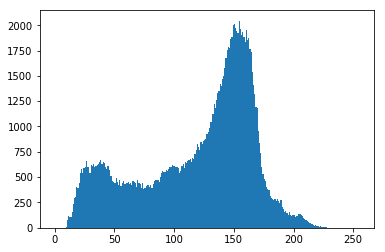

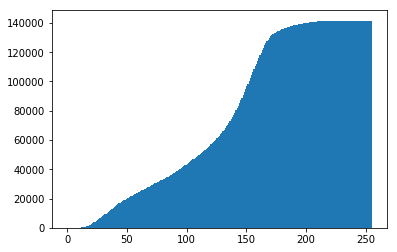

('./data/image_filtered_gaussian_3.png',
 <PIL.Image.Image image mode=RGB size=237x199 at 0x7F604AF44748>)

In [101]:
p7_util.p7_filter_gaussian(image_pil, size=3, title=str(), xlabel=str(), ylabel=str()\
, is_show=False)

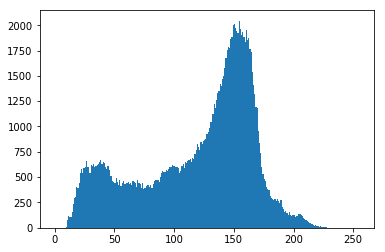

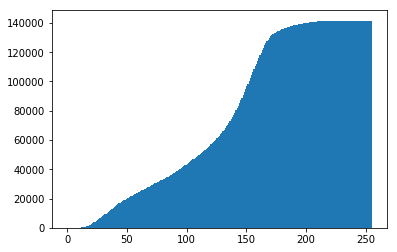

In [108]:
file, image_pil_gaussian = p7_util.p7_filter_gaussian(image_pil, size=3)

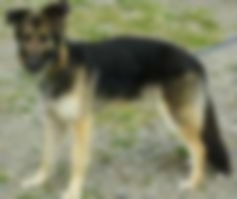

In [109]:
image_pil_gaussian

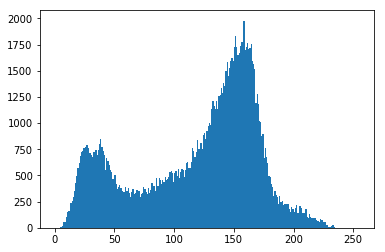

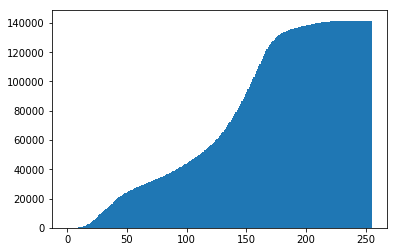

In [115]:
file, image_pil_median = p7_util.p7_filter_median(image_pil, size=5)

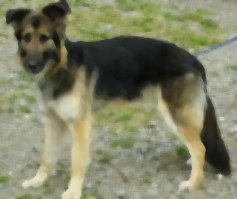

In [116]:
image_pil_median

In [87]:
image_color = cv2.imread(image_filename)

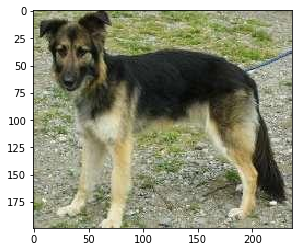

In [88]:
plt.imshow(cv2.cvtColor(image_color, cv2.CV_32S))

In [89]:
image_gray = to_gray(image_color)

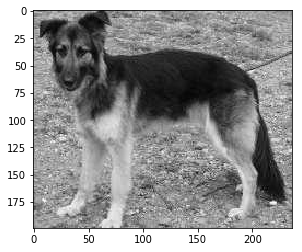

In [90]:
plt.imshow(image_gray, cmap='gray');

In [92]:
kp, desc  = gen_sift_features(image_gray)

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [ ]:
# generate SIFT keypoints and descriptors
octo_front_kp, octo_front_desc = gen_sift_features(octo_front_gray)
octo_offset_kp, octo_offset_desc = gen_sift_features(octo_offset_gray)

print 'Here are what our SIFT features look like for the front-view octopus image:'
show_sift_features(octo_front_gray, octo_front, octo_front_kp);